In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

┌ Info: Precompiling ReactiveMPPaperExperiments [adcd1038-27e6-4580-819b-caa5dba07e45]
└ @ Base loading.jl:1342
┌ Warning: Package ReactiveMPPaperExperiments does not have ReactiveMP in its dependencies:
│ - If you have ReactiveMPPaperExperiments checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMPPaperExperiments
└ Loading ReactiveMP into ReactiveMPPaperExperiments from project dependency, future warnings for ReactiveMPPaperExperiments are suppressed.


In [3]:
using CairoMakie # Plots related stuff
using Turing, Distributions, LinearAlgebra, Random # Bayesian Inference packages
using BenchmarkTools, DataFrames, Query # Analysis tools

In this section we want to compare results and performance of ReactiveMP.jl with another probabilistic programming library which is called Turing.jl. Turing is a general probabilistic programming toolbox and does not use message passing for inference procedure, but sampling. Message passing has an advantage over sampling approach for conjugate models (which our linear gaussian state space model is) because it may fallback to analytically tractable update rules, where sampling cannot. 

In [4]:
Turing.@model LinearGaussianSSM(y, A, B, P, Q) = begin
    n = length(y)

    # State sequence.
    x = Vector(undef, n)

    d = first(size(A))
    pm = zeros(d)
    pc = Matrix(Diagonal(100.0 * ones(d)))

    # Observe each point of the input.
    x[1] ~ MvNormal(pm, pc)
    y[1] ~ MvNormal(B * x[1], Q)

    for t in 2:n
        x[t] ~ MvNormal(A * x[t - 1], P)
        y[t] ~ MvNormal(B * x[t], Q)
    end
end;

In [5]:
params = let 
    seed = 42
    n    = 50
    d    = 2
    θ    = π / 20

    A = rotation_matrix(θ)
    B = diagonal_matrix([ 1.3, 0.7 ])
    P = diagonal_matrix([ 1.0, 1.0 ])
    Q = diagonal_matrix([ 1.0, 1.0 ]);

    @strdict seed n d θ A B P Q
end;

We use Turing's builtin HMC sampler to perform inference on this model.

In [6]:
function inference_turing(observations, params; nsamples = 250, seed = 42)
    @unpack A, B, P, Q = params
    rng = MersenneTwister(seed)
    return Turing.sample(rng, 
        LinearGaussianSSM(observations, A, B, P, Q), Turing.HMC(0.1, 10), 
        nsamples
    )
end

inference_turing (generic function with 1 method)

In [7]:
x_turing, y_turing = generate_data(LGSSMModel(), params);
x_turing_estimated = inference_turing(y_turing, params);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


In [8]:
println("Average MSE: $(average_mse(x_turing, x_turing_estimated, :x, MvNormal))")

Average MSE: 194.7855967730789


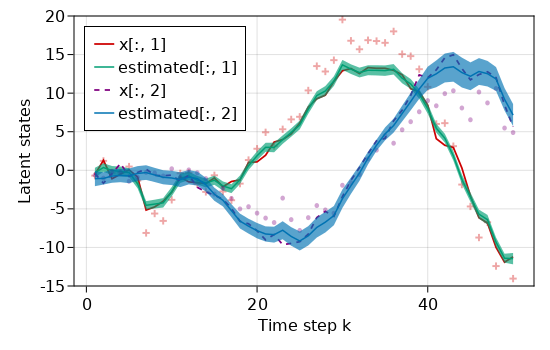

In [9]:
let
    reshape_data        = (data) -> transpose(reduce(hcat, data))
    reshape_turing_data = (data) -> transpose(reshape(data, (2, Int(length(data) / 2))))

    ylimit = (-15, 20)
    c = Makie.wong_colors()
    
    n_turing = length(y_turing)
    samples  = get(x_turing_estimated, :x)
    
    x_inferred_means = reshape_turing_data([ mean(samples.x[i].data) for i in 1:2n_turing ]) |> collect |> eachrow |> collect
    x_inferred_stds = reshape_turing_data([ std(samples.x[i].data) for i in 1:2n_turing ]) |> collect |> eachrow |> collect

    range = 1:n_turing

    fig = Figure(resolution = (550, 350))
    ax  = Makie.Axis(fig[1, 1], xlabel = "Time step k", ylabel = "Latent states")

    ylims!(ax, ylimit)

    # Real dim1

    lines!(ax, range, x_turing |> edim(1), color = :red3, linewidth = 1.75, label = "x[:, 1]")
    scatter!(ax, range, y_turing |> edim(1), color = (:red3, 0.35), markersize = 10, marker = :cross)

    # Estimated dim1

    lines!(ax, range, x_inferred_means |> edim(1), color = c[3], label = "estimated[:, 1]")
    band!(ax, range, (x_inferred_means |> edim(1)) .+ (x_inferred_stds |> edim(1)), (x_inferred_means |> edim(1)) .- (x_inferred_stds |> edim(1)), color = (c[3], 0.65))

    # Real dim2

    lines!(ax, range, x_turing |> edim(2), color = :purple, linewidth = 1.75, linestyle = :dash, label = "x[:, 2]")
    scatter!(ax, range, y_turing |> edim(2), color = (:purple, 0.35), markersize = 6, marker = :circle)

    # Estimated dim2

    lines!(ax, range, x_inferred_means |> edim(2), color = c[1], label = "estimated[:, 2]")
    band!(ax, range, (x_inferred_means |> edim(2)) .+ (x_inferred_stds |> edim(2)), (x_inferred_means |> edim(2)) .- (x_inferred_stds |> edim(2)), color = (c[1], 0.65))

    axislegend(ax, position = :lt, labelsize = 16)

    @saveplot fig "lgssm_turing_inference"
end

### Benchmark

In [10]:
function make_benchmark_data(n, d, seed)
    rng = MersenneTwister(seed)

    A = random_rotation_matrix(rng, d)
    B = Matrix(Diagonal(ones(d) .+ rand(rng, -0.5:0.1:1.0, d)))
    P = Matrix(Diagonal(2.0 * ones(d)))
    Q = Matrix(Diagonal(2.0 * ones(d)))

    params = @strdict n d seed A B P Q

    x, y = generate_data(LGSSMModel(), params)

    return x, y, params
end

make_benchmark_data (generic function with 1 method)

In [11]:
function run_turing_benchmark(params)
    @unpack n, seed, d, nsamples = params
    
    x, y, params = make_benchmark_data(n, d, seed)

    x_estimated = inference_turing(y, params, nsamples = nsamples, seed = seed);
    benchmark   = @benchmark inference_turing($y, $params, nsamples = $nsamples, seed = $seed)
    amse = average_mse(x, x_estimated, :x, MvNormal)
    
    emse_range = seed:(seed + 10)
    
    emse = 1.0 / length(emse_range) * mapreduce(+, emse_range) do _seed
        local x, y, params = make_benchmark_data(n, d, _seed)
        local x_estimated = inference_turing(y, params, nsamples = nsamples, seed = _seed);
        return average_mse(x, x_estimated, :x, MvNormal)
    end

    output = @strdict n seed d amse emse nsamples x_estimated benchmark

    return output
end

run_turing_benchmark (generic function with 1 method)

In [12]:
# Here we create a list of parameters we want to run our benchmarks with
benchmark_allparams_turing = dict_list(Dict(
    "n"        => [ 100, 200, 300 ], # 500, 1000
    "seed"     => 42,
    "d"        => [ 2, 3, 4 ],
    "nsamples" => [ 250, 500 ]
));

In [ ]:
# First run maybe slow, you may track the progress in the terminal
# Subsequent runs will not create new benchmarks 
# but will reload it from data folder
turing_benchmarks = map(benchmark_allparams_turing) do params
    path = datadir("benchmark", "lgssm", "turing")
    result, _ = produce_or_load(path, params; tag = false) do p
        run_turing_benchmark(p)
    end
    return result
end;

┌ Info: File /Users/bvdmitri/.julia/dev/ReactiveMPPaperExperiments/data/benchmark/lgssm/turing/d=2_n=100_nsamples=250_seed=42.jld2 does not exist. Producing it now...
└ @ DrWatson /Users/bvdmitri/.julia/packages/DrWatson/OgRKj/src/saving_files.jl:61
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:37
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:40
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:31
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:31
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:31
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30
Sampling: 100%|███████████████

Here we compare `Turing.jl` performance results against smoothing algorithm performed in `ReactiveMP.jl`. We can see that `ReactiveMP.jl` outperforms `Turing.jl` significantly. It is worth noting that this model contains many conjugate prior and likelihood pairings that lead to analytically computable Bayesian posteriors. For these types of models, ReactiveMP.jl takes advantage of the conjugate pairings and beats general-purpose probabilistic programming packages like Turing.jl easily in terms of computational load, speed, memory and accuracy. On the other hand, Turing.jl is currently still capable of running inference for a broader set of models.

In [56]:
target_nsamples = 500
target_seed = 42
target_d = 2

2

In [57]:
let
    white_list   = [ "n", "seed", "d", "nsamples", "amse" ]
    special_list = [
        :min => (data) -> string(round(minimum(data["benchmark"]).time / 1_000_000_000, digits = 3), "s"),
        :mean => (data) -> string(round(mean(data["benchmark"]).time / 1_000_000_000, digits = 3), "s"),
        :amse_n => (data) -> string(round(data["amse"] / data["n"], digits = 2)),
        :emse_n => (data) -> string(round(data["emse"] / data["n"], digits = 2))
    ]

    # df_turing = collect_results(datadir("benchmark", "lgssm", "turing"), white_list = white_list, special_list = special_list, verbose = false)
    df_turing = collect_benchmarks(turing_benchmarks, white_list = white_list, special_list = special_list, verbose = false)

    query_turing = @from row in df_turing begin
        @where row.seed == target_seed && row.d == target_d && row.nsamples == target_nsamples
        @orderby ascending(row.n)
        @select { row.n, row.min, row.mean, row.amse_n, row.emse_n }
    end

    DataFrame(query_turing)
end

,n,min,mean,amse_n,emse_n
,Int64,String,String,String,String
1,50,12.952s,12.952s,14.45,6.27
